# Baseline model
Model pour s'habituer au dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#pip install pandas-profiling
import pandas_profiling
import matplotlib.pyplot as plt
# pip install scikit-plot
import scikitplot as skplt
#pip install missingno
import missingno as msno
from sklearn.metrics import roc_auc_score
%matplotlib inline

#pip install xgboost
import xgboost as xgb
#pip install lightgbm
import lightgbm as lgb

On importe les dataset

In [2]:
data_application_test = pd.read_csv('../data/application_test.csv')
data_application_train = pd.read_csv('../data/application_train.csv')
# data_bureau_balance = pd.read_csv('../data/bureau_balance.csv')
# data_credit_card_balance  = pd.read_csv('../data/credit_card_balance.csv')
# data_bureau = pd.read_csv('../data/bureau.csv')
# data_installments_payments = pd.read_csv('../data/installments_payments.csv')
# data_POS_CASH_balance = pd.read_csv('../data/POS_CASH_balance.csv')
# data_previous_application = pd.read_csv('../data/previous_application.csv')
# data_HomeCredit_columns_description = pd.read_csv('../data/HomeCredit_columns_description.csv')
data_sample_submission = pd.read_csv('../data/sample_submission.csv')

On nettoie le nom des colonnes car, c'est pénible de manipuler les noms avec des majuscules

In [3]:
data_application_train.columns = [str.lower(x) for x in data_application_train.columns]
data_application_test.columns = [str.lower(x) for x in data_application_test.columns]

In [4]:
data_application_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Analyse 

In [5]:
profile = pandas_profiling.ProfileReport(data_application_train)
profile

Number of variables,122
Number of observations,307511
Total Missing (%),9.6%
Total size in memory,286.2 MiB
Average record size in memory,976.0 B
Numeric,39
Categorical,16
Boolean,33
Date,0
Text (Unique),0
Rejected,34


On essaye d'avoir le max de features au début, un trie sera nécéssair par la suite. 250 features environ sans compter les autres dataset !

## Data cleaning

Très simple on transforme toutes les variables qualitatives en variables booléenne.

In [6]:
data = data_application_train.copy()
rejected_variables = profile.get_rejected_variables()
data = data.drop(rejected_variables,axis=1)

In [7]:
data = pd.get_dummies(data)

In [8]:
data =data.fillna(0)

In [9]:
data.head()

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,region_population_relative,days_birth,days_employed,days_registration,...,housetype_mode_terraced house,wallsmaterial_mode_Block,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,emergencystate_mode_No,emergencystate_mode_Yes
0,100002,1,0,202500.0,406597.5,24700.5,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,0.003541,-16765,-1188,-1186.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.0,135000.0,6750.0,0.010032,-19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,0.008019,-19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,0.028663,-19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0


## Modèle

Regression logistique pour commencer.  
Les prochain modèles à tester seront :
- Xgboost
- LightGBM

In [10]:
target = data.target
#On drop l'ID mais je n'ai pas vérifier s'il influe sur le résultat
data_train = data.drop(['sk_id_curr','target'],axis=1)
col = data_train.columns

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_train = pd.DataFrame(data_train)
data_train.columns = col

In [12]:
data_train.head()

,cnt_children,amt_income_total,amt_credit,amt_annuity,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,...,housetype_mode_terraced house,wallsmaterial_mode_Block,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,emergencystate_mode_No,emergencystate_mode_Yes
0,-0.577538,0.142129,-0.478095,-0.166065,-0.149452,1.506880,-0.456215,0.379837,0.579154,-0.455284,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,1.935056,-0.133215,0.963763,-0.08734
1,-0.577538,0.426792,1.725450,0.592710,-1.252750,-0.166821,-0.460115,1.078697,1.790855,-0.455284,...,-0.062904,5.677469,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,0.963763,-0.08734
2,-0.577538,-0.427196,-1.152888,-1.404507,-0.783451,-0.689509,-0.453299,0.206116,0.306869,2.430559,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,-1.037599,-0.08734
3,-0.577538,-0.142533,-0.711430,0.177929,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,-0.455284,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,-1.037599,-0.08734
4,-0.577538,-0.199466,-0.213734,-0.361658,0.563570,-0.892535,-0.473210,0.191639,-0.307263,-0.455284,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-0.522963,-0.516781,-0.133215,-1.037599,-0.08734


Split du dataset d'entrainement. Un set de validation sera crée par la suite

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_train, target, test_size=0.4, random_state=1)

Baseline LogReg

In [14]:
regleg = LogisticRegression()
pred = regleg.fit(X_train,y_train).predict_proba(X_test)

In [15]:
print(roc_auc_score(y_test, pred[:,1]))

0.7283958320444948


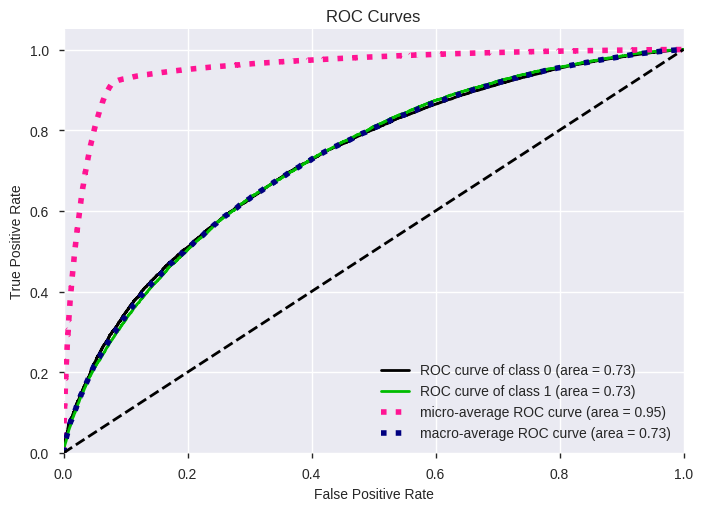

In [16]:
skplt.metrics.plot_roc(y_test, pred)

Models

In [17]:
xgbb = xgb.XGBClassifier()
prediction_xgb = xgbb.fit(X_train,y_train).predict_proba(X_test)
print(roc_auc_score(y_test, prediction_xgb[:,1]))

0.749823442824759


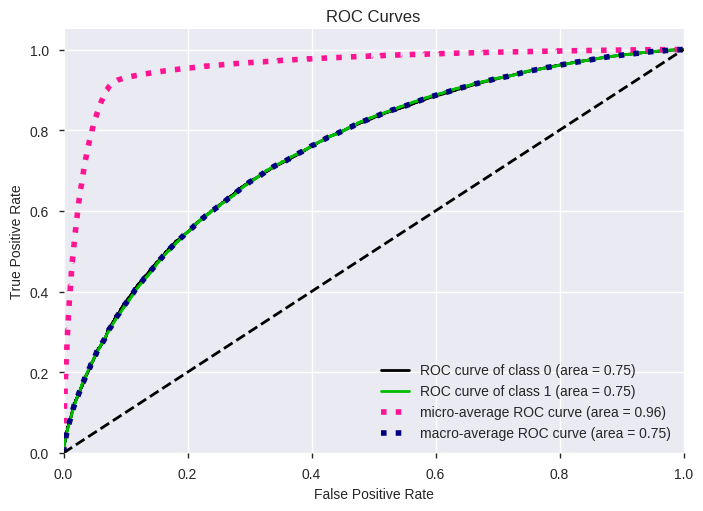

In [18]:
skplt.metrics.plot_roc(y_test, prediction_xgb)

In [19]:
lightgbm = lgb.LGBMClassifier()
prediction_lgb = lightgbm.fit(X_train,y_train).predict_proba(X_test)
print(roc_auc_score(y_test, pred[:,1]))

0.7283958320444948


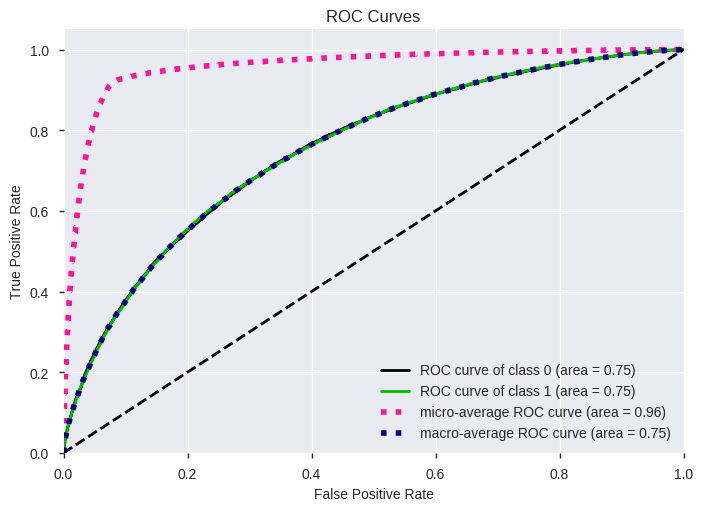

In [20]:
skplt.metrics.plot_roc(y_test, prediction_lgb)

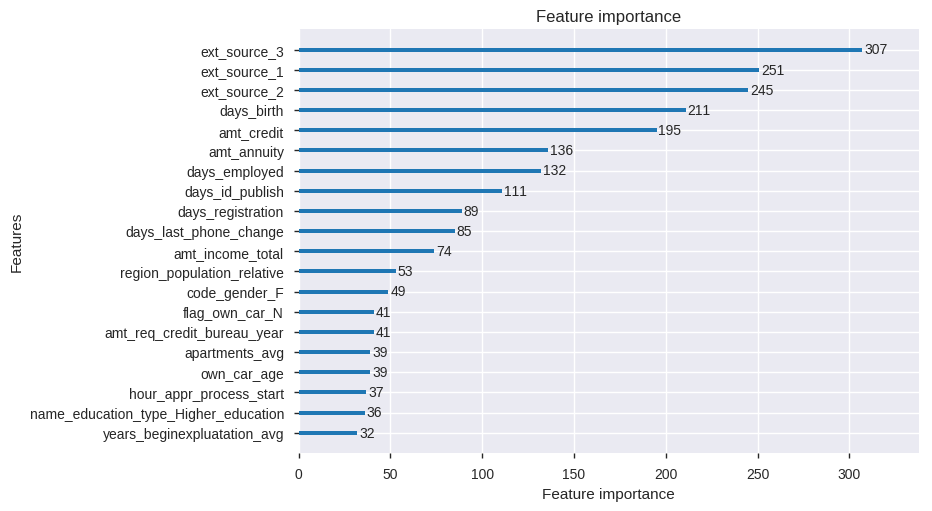

In [21]:
lgb.plot_importance(lightgbm,max_num_features=20)

## Submission  
Il manque des occurence pour le dataset test. On rajoute donc les colonnes du dataset d'entrainement dans celui du test.

In [22]:
test = pd.get_dummies(data_application_test) 

In [23]:
# a = np.setdiff1d(app_train.columns, test.columns)
missing_cols = set( data_train.columns ) - set( test.columns )

In [24]:
# test['code_gender_XNA'] = 0
# test['name_family_status_Unknown'] = 0
# test['name_income_type_Maternity leave'] = 0
for c in missing_cols:
    test[c] = 0
test = test[data_train.columns]

In [25]:
test.fillna(0,inplace=True)
#test.drop('sk_id_curr',axis=1,inplace=True)
c_test = test.columns
test = scaler.fit_transform(test)
test = pd.DataFrame(test)
test.columns = c_test

In [26]:
prediction = xgbb.predict_proba(test)

In [27]:
data_sample_submission['TARGET'] = prediction[:,1]

In [28]:
data_sample_submission.to_csv('xgbv1.csv',index=False)